In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import NiceCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator, RealNvpCalibrator, TempScalingCalibrator 

C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\f

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(1)

### Helper methods:

In [6]:
def add_spoiling_samples(ax, pred_probs, target, probs):
    indv_nll = -np.sum(target*np.log(pred_probs+1e-7), axis=1)
    # spoiling_idx = np.argsort(indv_nll)[:-21:-1]
    spoiling_probs = probs[indv_nll>=np.log2(3), :]
    spoiling_target = np.argmax(target[indv_nll>=np.log2(3), :], axis=1)

    ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)
    

    return ax

In [7]:
def nll_curve(probs, target):
    indv_nll = -np.sum(target*np.log(probs+1e-7), axis=1)
    indv_nll = np.sort(indv_nll)[::-1]
    return indv_nll

## Load data

In [8]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [9]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

## Uncalibrated:

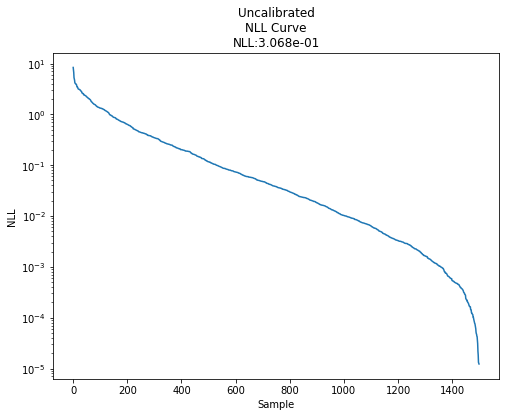

In [10]:
# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nll_curve(softmax(val_logits, 1), val_target))
ax.set_title('Uncalibrated\nNLL Curve\nNLL:{:.3e}'.format(neg_log_likelihood(softmax(val_logits, 1), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Sample')
ax.set_yscale('log')

plt.show();

## Temp-Scaling Baseline:

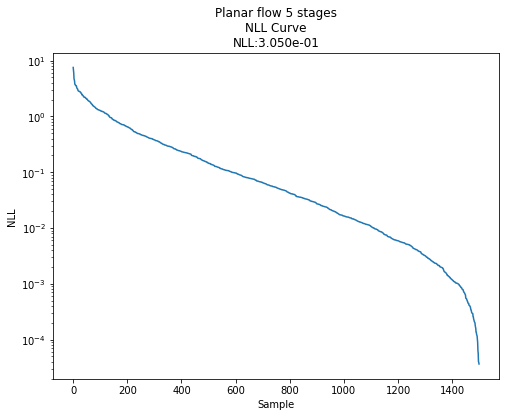

In [11]:
temp_cal = TempScalingCalibrator(val_logits, val_target)

# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nll_curve(temp_cal(val_logits), val_target))
ax.set_title('Planar flow 5 stages\nNLL Curve\nNLL:{:.3e}'.format(neg_log_likelihood(temp_cal(val_logits), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Sample')
ax.set_yscale('log')

plt.show();

## Calibrating some flows:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fitted in 199.761s


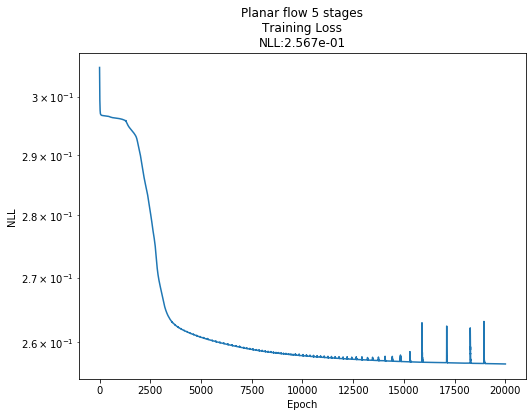

In [12]:
epochs = 20000
batch_size = val_target.shape[0]

t0 = time.time()
pln_cal = PlanarFlowCalibrator(val_logits, val_target, layers=10, epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pln_cal.history.history['loss'])
ax.set_title('Planar flow 5 stages\nTraining Loss\nNLL:{:.3e}'.format(neg_log_likelihood(pln_cal(val_logits), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Epoch')
ax.set_yscale('log')

plt.show();

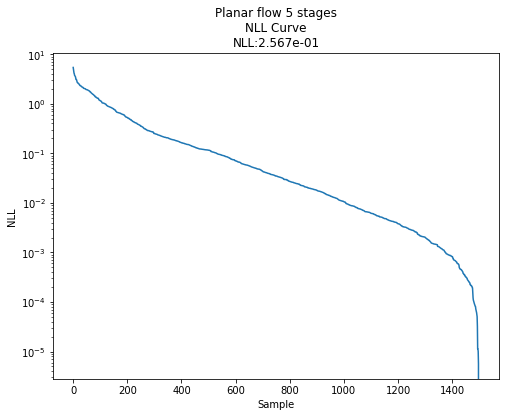

In [13]:
# Plot NLL curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nll_curve(pln_cal(val_logits), val_target))
ax.set_title('Planar flow 5 stages\nNLL Curve\nNLL:{:.3e}'.format(neg_log_likelihood(pln_cal(val_logits), val_target)))
ax.set_ylabel('NLL')
ax.set_xlabel('Sample')
ax.set_yscale('log')

plt.show();

## Comparison:

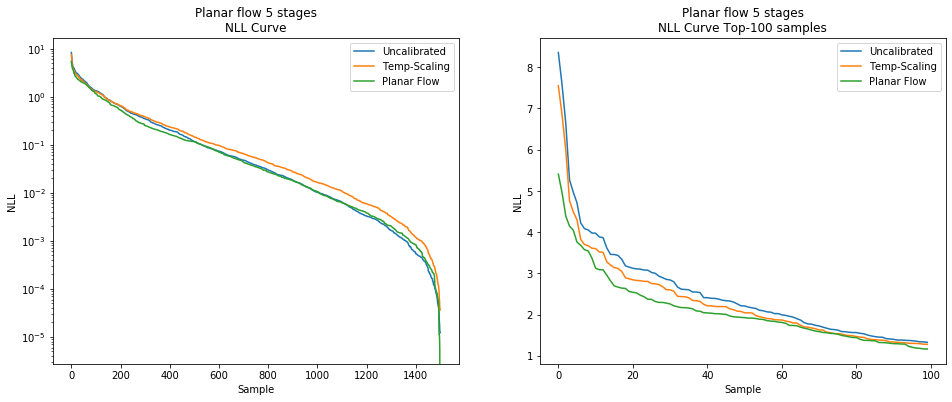

In [14]:
# Plot NLL curve
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))
ax_arr[0].plot(nll_curve(softmax(val_logits, 1), val_target), label='Uncalibrated')
ax_arr[0].plot(nll_curve(temp_cal(val_logits), val_target), label='Temp-Scaling')
ax_arr[0].plot(nll_curve(pln_cal(val_logits), val_target), label='Planar Flow')
ax_arr[0].set_title('Planar flow 5 stages\nNLL Curve')
ax_arr[0].legend()
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('Sample')
ax_arr[0].set_yscale('log')

ax_arr[1].plot(nll_curve(softmax(val_logits, 1), val_target)[:100], label='Uncalibrated')
ax_arr[1].plot(nll_curve(temp_cal(val_logits), val_target)[:100], label='Temp-Scaling')
ax_arr[1].plot(nll_curve(pln_cal(val_logits), val_target)[:100], label='Planar Flow')
ax_arr[1].set_title('Planar flow 5 stages\nNLL Curve Top-100 samples')
ax_arr[1].legend()
ax_arr[1].set_ylabel('NLL')
ax_arr[1].set_xlabel('Sample')

plt.show();